### Nome: Matheus Atanasio de Morais Melo
### Email: mamm@cessar.school
### Link do Dataset Escolhido: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small/data

In [36]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import random_split
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix, classification_report

In [37]:
df = pd.read_csv("styles.csv", on_bad_lines='skip', encoding='utf-8')

In [38]:
df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


In [43]:
df['masterCategory'].value_counts()

masterCategory
Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64

In [4]:
img_id = df.iloc[0]['id']
img_path = f"images/{int(img_id)}.jpg"

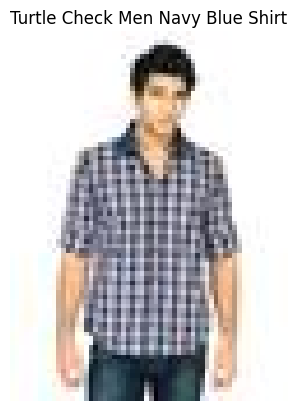

In [5]:
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(df.iloc[0]['productDisplayName'])
plt.show()

In [6]:
# Caminho para a pasta de imagens
image_folder = "images"

# Converte a coluna de id para string
df['id'] = df['id'].astype(str)

# Lista de arquivos de imagem disponíveis (sem extensão)
available_images = {fname.split('.')[0] for fname in os.listdir(image_folder) if fname.endswith('.jpg')}

# Lista de IDs esperados a partir do CSV
expected_images = set(df['id'])

# IDs que estão no CSV mas não estão na pasta de imagens
missing_images = expected_images - available_images

# Exibir resultado
print(f"Total de imagens esperadas: {len(expected_images)}")
print(f"Total de imagens encontradas: {len(available_images)}")
print(f"Total de imagens faltando: {len(missing_images)}")

# Exibir o id imagens faltantes (se houver)
if missing_images:
    print("IDs faltando:", list(missing_images)[:10])
else:
    print("Nenhuma imagem faltando! Tudo certo :)")


Total de imagens esperadas: 44424
Total de imagens encontradas: 44441
Total de imagens faltando: 5
IDs faltando: ['39401', '39425', '39403', '12347', '39410']


In [7]:
# Cria um novo df sem a imagens faltantes
df = df[df['id'].isin(available_images)].reset_index(drop=True)

In [8]:
'''transform = transforms.Compose([
    transforms.Resize((64, 64)),  # ou 128x128, depende da sua rede
    transforms.ToTensor(),        # converte a imagem em tensor e normaliza de 0-255 para 0-1
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # normaliza para [-1, 1]
])'''
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [9]:
transform

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

# Criação do Dataset

In [10]:
# Define e instancia uma classe de dataset personalizada do pytorch
# Serve para organizar os dados de entrada e saída de forma que possam ser utilizados por um dataloader
from torch.utils.data import Dataset
from PIL import Image
import os

class FashionProducts(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_folder = image_folder
        self.transform = transform

        # Mapeia cada categoria para um número
        self.label_map = {cat: i for i, cat in enumerate(self.data['masterCategory'].unique())}
        self.data['label'] = self.data['masterCategory'].map(self.label_map)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_folder, f"{int(row['id'])}.jpg")
        image = Image.open(img_path).convert("RGB")
        label = self.data.iloc[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label


In [33]:
dataset = FashionProducts(df, "images", transform=transform)


train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])

print(f"len treinamento: {len(train_data)}")
print(f"len val: {len(val_data)}")

len treinamento: 31093
len val: 13326


## Criação da Rede

In [25]:
# Definição da rede. Trata-se de uma rede neural convolucional (CNN)

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)   # Camada convolucional (entrada de 3 canais, 32 filtros de saída)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)  # Camada convolucional (entrada de 32 canais, 64 filtros de saída)
        self.dropout1 = nn.Dropout(0.25)      # Dropout após convolução (25% dos neurônios desligados aleatoriamente para evitar overfitting)
        self.dropout2 = nn.Dropout(0.5)       # Dropout após primeira camada linear (50% dos neurônios desligados)
        self.fc1 = nn.Linear(64 * 30 * 30, 128)  # Primeira camada linear (64 canais * 30x30)
        self.fc2 = nn.Linear(128, num_classes)   # Segunda camada linear, onde a saída é num_classer, definido posteriormente na chamada da instancia

    def forward(self, x):
        x = self.conv1(x)                 # Primeira convolução
        x = F.relu(x)                     # Aplica função de ativação ReLU
        x = self.conv2(x)                 # Segunda convolução
        x = F.relu(x)                     # Segunda ativação ReLu
        x = F.max_pool2d(x, 2)            # Reduz o tamanho espacial pela metade (pooling 2x2)
        x = self.dropout1(x)              # Aplica o primeiro dropout para regularizar o modelo
        x = torch.flatten(x, 1)           # "Achata" o tensor para a camada linear
        x = self.fc1(x)                   # Primeira camada linear
        x = F.relu(x)                     # Aplicação do ReLU após camada linear
        x = self.dropout2(x)              # Segundo dropout
        x = self.fc2(x)                   # Última camada 
        output = F.log_softmax(x, dim=1)  # Aplica log_softmax para obter probabilidades logaritmicas
        return output

# Treinamento

In [13]:
# Função de treino
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                  f" ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

In [14]:
# Função de teste
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"\nValidation set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} "
          f"({accuracy:.2f}%)\n")
    return accuracy, test_loss

# Avaliação

In [30]:
# Detecta se CUDA está disponível
use_cuda = torch.cuda.is_available()
torch.manual_seed(1111)
device = torch.device("cuda" if use_cuda else "cpu")

# Hiperparâmetros
train_kwargs = {'batch_size': 200}
test_kwargs = {'batch_size': 1000}
if use_cuda:
    cuda_kwargs = {'num_workers': 1, 
                   'pin_memory': True, 
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

# DataLoaders
train_loader = DataLoader(train_data, **train_kwargs)
val_loader = DataLoader(val_data, **test_kwargs)

# Número de classes no rótulo
num_classes = df['masterCategory'].nunique()
model = Net(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
best_acc = 0


# Loop de treinamento
epochs = 30
for epoch in range(1, epochs + 1):
    train(log_interval=10, model=model, device=device, train_loader=train_loader, optimizer=optimizer, epoch=epoch)
    acc, val_loss = test(model, device, val_loader)
    scheduler.step(val_loss)  

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "fashion_cnn_best.pt")
        print(f"Novo melhor modelo salvo (acurácia: {acc:.2f}%)")

Epoch 1 [0/31093 (0%)]	Loss: 1.945462
Epoch 1 [2000/31093 (6%)]	Loss: 0.757653
Epoch 1 [4000/31093 (13%)]	Loss: 0.482005
Epoch 1 [6000/31093 (19%)]	Loss: 0.417292
Epoch 1 [8000/31093 (26%)]	Loss: 0.251633
Epoch 1 [10000/31093 (32%)]	Loss: 0.249568
Epoch 1 [12000/31093 (38%)]	Loss: 0.207414
Epoch 1 [14000/31093 (45%)]	Loss: 0.195692
Epoch 1 [16000/31093 (51%)]	Loss: 0.201705
Epoch 1 [18000/31093 (58%)]	Loss: 0.220740
Epoch 1 [20000/31093 (64%)]	Loss: 0.169841
Epoch 1 [22000/31093 (71%)]	Loss: 0.196653
Epoch 1 [24000/31093 (77%)]	Loss: 0.233089
Epoch 1 [26000/31093 (83%)]	Loss: 0.249353
Epoch 1 [28000/31093 (90%)]	Loss: 0.223831
Epoch 1 [30000/31093 (96%)]	Loss: 0.142707

Validation set: Average loss: 0.1513, Accuracy: 12747/13326 (95.66%)

Novo melhor modelo salvo (acurácia: 95.66%)
Epoch 2 [0/31093 (0%)]	Loss: 0.181354
Epoch 2 [2000/31093 (6%)]	Loss: 0.200575
Epoch 2 [4000/31093 (13%)]	Loss: 0.147682
Epoch 2 [6000/31093 (19%)]	Loss: 0.179365
Epoch 2 [8000/31093 (26%)]	Loss: 0.097325
Ep

In [22]:
# Tive que reiniciar o notebook, aí carreguei o melhor modelo salvo

# Carregar os dataloaders e modelo como antes
train_kwargs = {'batch_size': 200}
test_kwargs = {'batch_size': 1000}

train_loader = DataLoader(train_data, **train_kwargs)
val_loader = DataLoader(val_data, **test_kwargs)

num_classes = df['masterCategory'].nunique()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net(num_classes)
model.load_state_dict(torch.load("fashion_cnn_best.pt", map_location=device))
model.to(device)
model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)

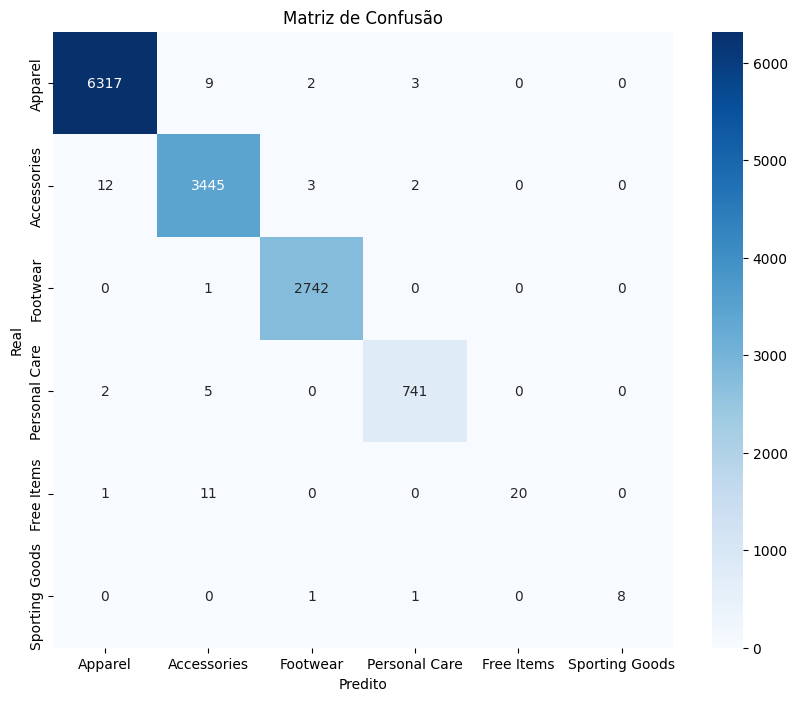

                precision    recall  f1-score   support

       Apparel       1.00      1.00      1.00      6331
   Accessories       0.99      1.00      0.99      3462
      Footwear       1.00      1.00      1.00      2743
 Personal Care       0.99      0.99      0.99       748
    Free Items       1.00      0.62      0.77        32
Sporting Goods       1.00      0.80      0.89        10

      accuracy                           1.00     13326
     macro avg       1.00      0.90      0.94     13326
  weighted avg       1.00      1.00      1.00     13326



In [23]:
# Coletar previsões e rótulos reais
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

# Descobrir quais classes realmente apareceram nas previsões ou rótulos
labels_presentes = sorted(set(all_labels + all_preds))

# Inverter o mapeamento dos rótulos para nomes legíveis
label_map_inv = {v: k for k, v in dataset.label_map.items()}
target_names_presentes = [label_map_inv[i] for i in labels_presentes]

# Matriz de confusão com nomes legíveis
cm = confusion_matrix(all_labels, all_preds, labels=labels_presentes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=target_names_presentes,
            yticklabels=target_names_presentes,
            cmap='Blues')
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

# Classification report apenas com as classes presentes
print(classification_report(all_labels, all_preds,
                            labels=labels_presentes,
                            target_names=target_names_presentes))

In [32]:
correct_per_class = np.diag(cm)
total_per_class = cm.sum(axis=1)
accuracy_per_class = correct_per_class / total_per_class

for i, name in enumerate(target_names_presentes):
    print(f"{name}: {accuracy_per_class[i]:.2%}")


Apparel: 99.78%
Accessories: 99.51%
Footwear: 99.96%
Personal Care: 99.06%
Free Items: 62.50%
Sporting Goods: 80.00%


In [27]:
topk = 3
correct_topk = 0
total = 0

with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, pred_topk = output.topk(topk, dim=1)
        correct_topk += (pred_topk == target.view(-1, 1)).sum().item()
        total += target.size(0)

print(f"Top-{topk} Accuracy: {correct_topk / total:.2%}")


Top-3 Accuracy: 99.97%


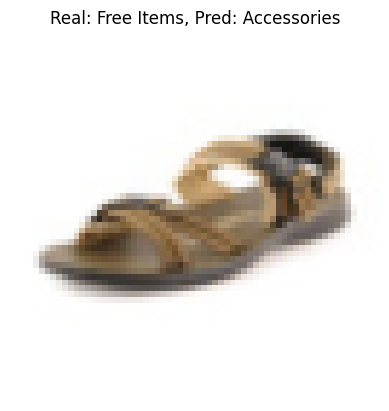

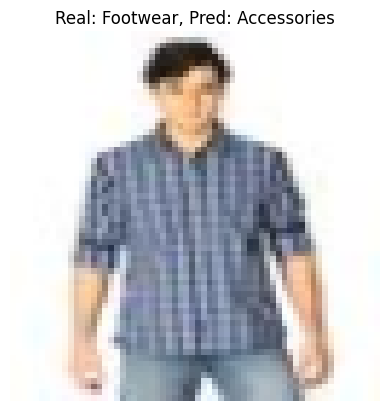

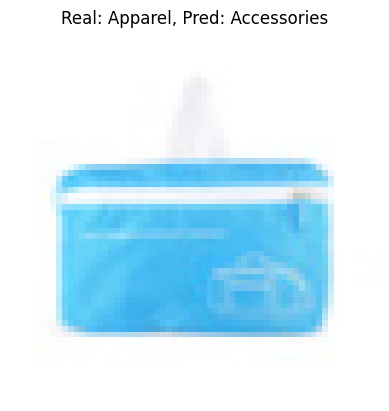

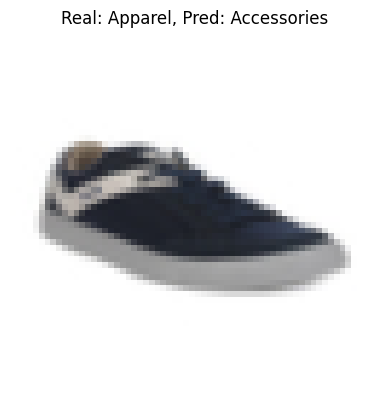

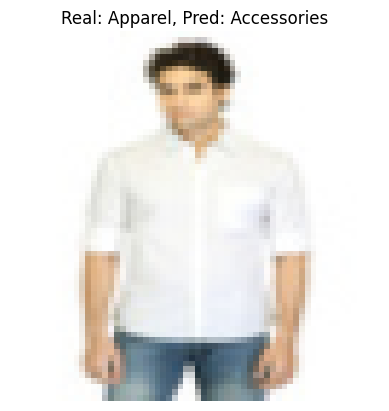

In [31]:
import matplotlib.pyplot as plt

dataset_eval = val_data.dataset
idx = 0
for i, (pred, label) in enumerate(zip(all_preds, all_labels)):
    if pred != label:
        img, _ = dataset_eval[i]
        plt.imshow(img.permute(1, 2, 0) * 0.5 + 0.5) 
        plt.title(f"Real: {label_map_inv[label]}, Pred: {label_map_inv[pred]}")
        plt.axis('off')
        plt.show()
        idx += 1
    if idx >= 5:
        break


# Discussões

## Contextualização

O objetivo desta atividade foi classificar artigos de vestuário de acordo com uma categoria específica, em particular a masterCategory (perceba que poderia ser qualquer a outra, a escolha foi arbitrária). Ou seja, para uma imagem de uma peça aleatória, queríamos que a rede fosse capaz de identificar se a peça percente, por exemplo, a Apparel ou Footwear. Como se trata de um problema de classificação de imagens, foi necessário o uso de uma rede neural convolucional (CNN), com uma arquitetura apropriada para esse tipo de tarefa.
Por que a utilização de convolução:
- Preservação da estrutura espacial da iamgem: Imagens têm uma estrutura espacial importante: pixels vizinhos tendem a ter relações entre si (bordas, texturas, etc.). A convolução preserva a estrutura local, ao contrária de uma rede totalmente conectada que "achata" a imagem.
- Redução de parâmetros: Por exemplo, uma imagem 100x100 RGB tem 30.000 entradas. Se cada pixel fosse conectado a todos os neurônios da próxima camada, o número de pesos seria enorme. Com convolução, utlizamos filtros pequenos que "varrem" a imagem. Os mesmos pesos são aplicados em diferentes regiões da imagem. Tudo isso reduz drasticamente o número de parâmetros e melhora a generalização;
- Extração de features locais: Cada filtro convolucional aprende a detectar padrões visuais locais (bordas, cantos, texturas, etc.). À medida que a imagem passa por diferentes camadas convolucionais, a rede aprende representações mais abstratas, essenciais para tarefas como classificação.

## Arquitetura do Problema

A rede, funções de treinamento e teste foram fortemente baseadas nas que estão presentes no notebook 4.6-MNIST_neuralnet.ipynb. As alterações feitas foram para adequar o código ao problema do presente notebook. A imagem passa por duas convoluções, seguidas de pooling, flatten e duas camadas lineares. Uma breve explicação da rede:
- A rede foi projetada para classificar imagens RGB redimensionadas para 64x64 pixels. Ela começa com duas camadas convolucionais: a primeira transforma os 3 canais de entrada em 32 mapas de ativação usando filtros 3x3, e a segunda expande isso para 64 mapas, também com filtros 3x3. Ambas as camadas são seguidas por funções de ativação ReLU, que introduzem não linearidades, e uma operação de max pooling 2x2 que reduz as dimensões espaciais de 60x60 para 30x30. Em seguida, aplica-se um dropout com taxa de 25% para reduzir o risco de overfitting.
- O volume resultante ([64, 30, 30]) é achatado em um vetor de 57.600 elementos e passado para uma camada totalmente conectada com 128 neurônios, seguida por uma ReLU e outro dropout mais agressivo (50%). Por fim, uma última camada linear projeta os dados para o número de classes do problema, e a função log_softmax transforma essa saída em log-probabilidades. Essa arquitetura é eficiente para detectar e aprender padrões visuais progressivamente mais complexos, enquanto mantém o número de parâmetros relativamente controlado e combate o overfitting com dropout.

Abaixo, alguns desenhos de como é mais ou menos a rede. É só uma representação de algo próximo.


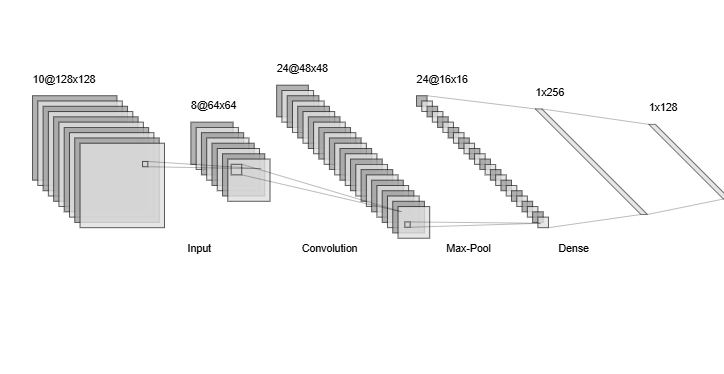

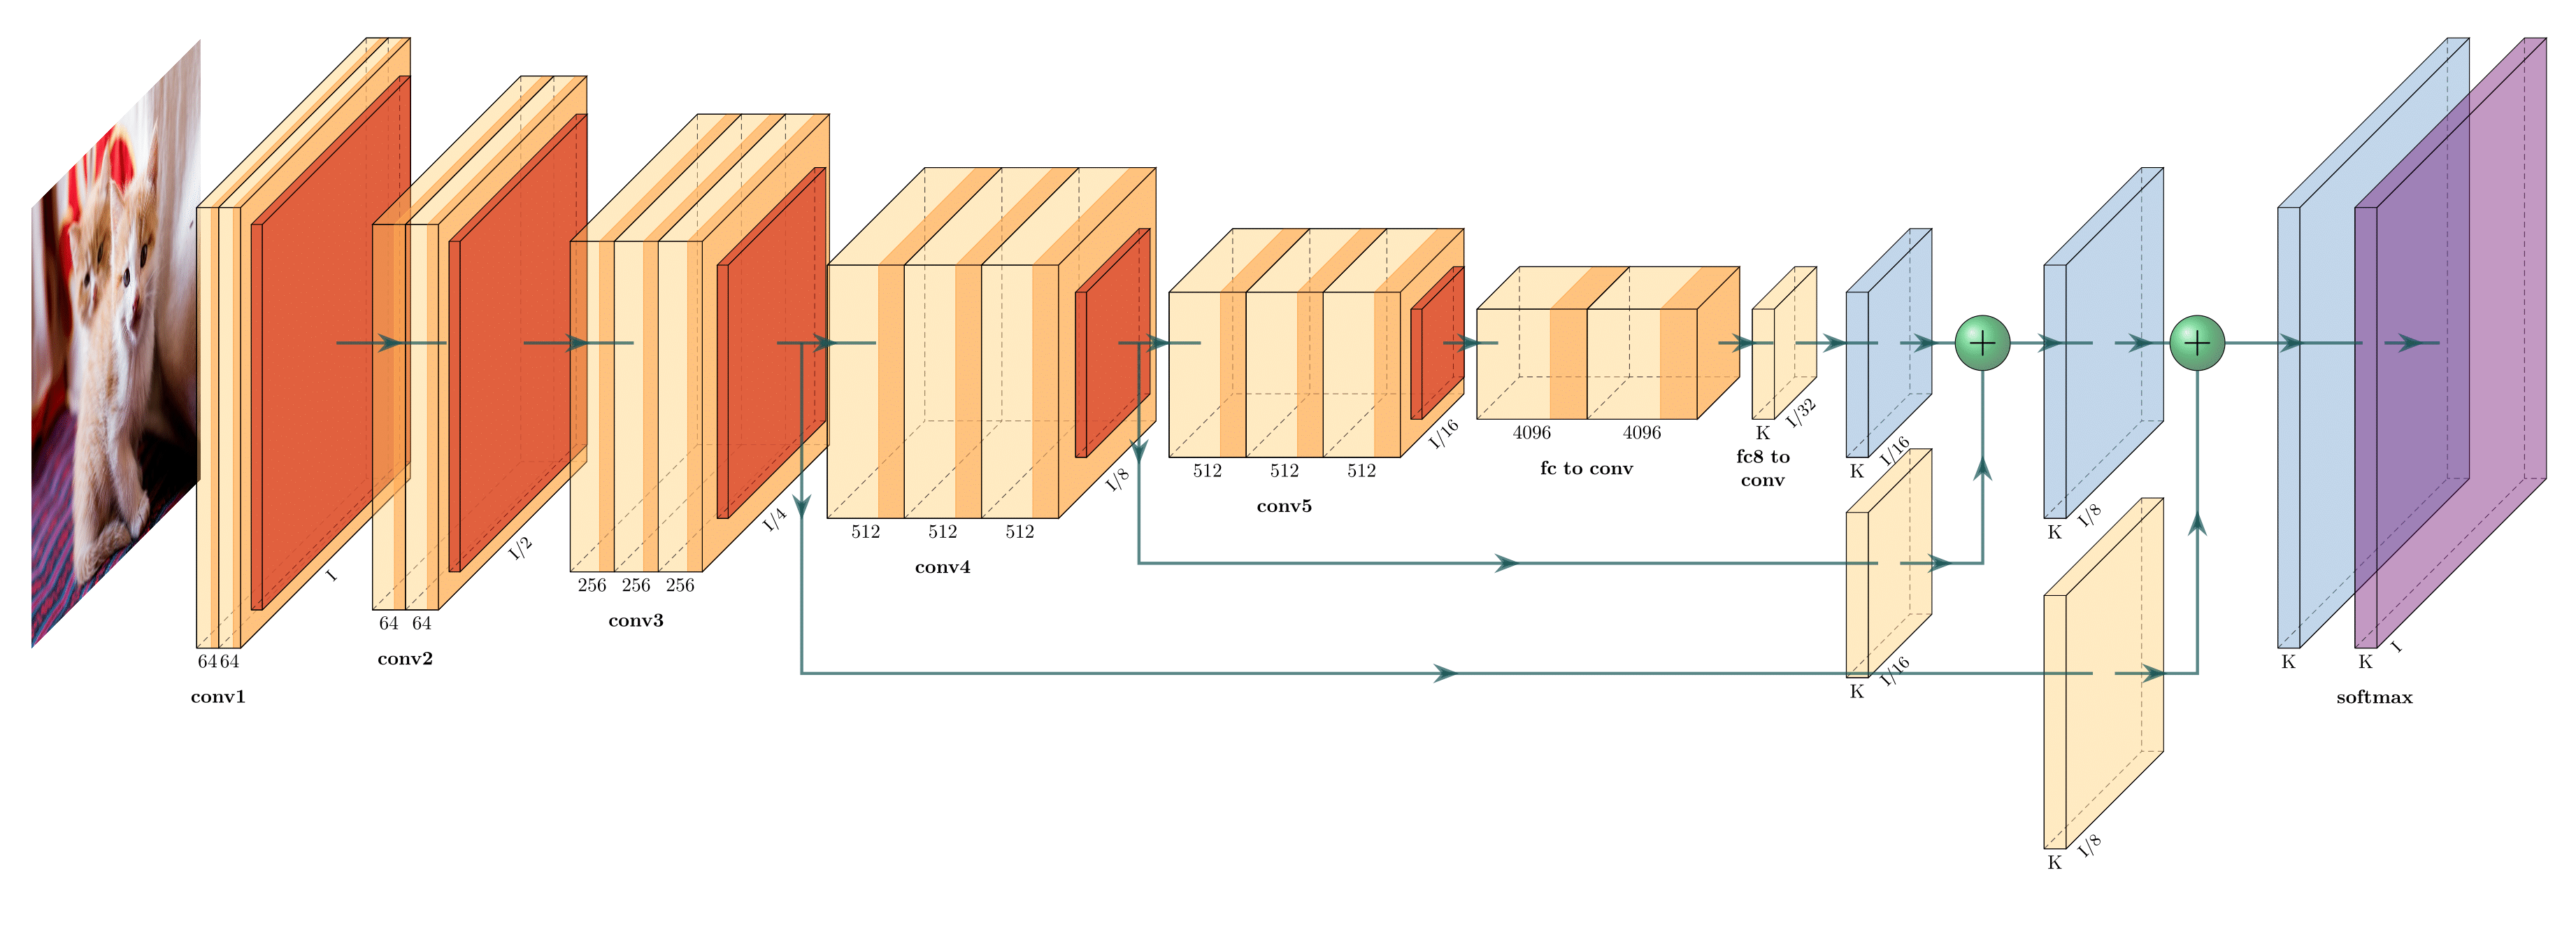

## Dificuldades

Como esperado, foi bastante demorado para treinar a rede — cerca de 3 horas. Apesar do meu computador ter GPU, não consegui utilizar CUDA. Também tive dificuldades em carregar as imagens no Colab, então todo o treinamento foi feito localmente. Na tentativa de tornar a rede mais rápida e eficiente, acabei me deparando com a possibilidade de utilizar um otimizador diferente: Adam. Esse otimizador é amplamente utilizado em tarefas de deep learning, pois combina o uso de momentum com uma taxa de aprendizado adaptativa, o que acelera e estabiliza o processo de convergência. Diferente de opções como o Adadelta, o Adam permite melhor controle da taxa de aprendizado inicial (lr=0.001) e apresenta desempenho superior em redes convolucionais aplicadas à classificação de imagens, como neste caso. Por isso, foi a escolha mais adequada para essa tarefa.
Outro ponto que acabei modificando foi o scheduler, por um motivo similar. Para controlar melhor o ritmo de aprendizado da rede durante o treinamento, optei por utilizar o agendador ReduceLROnPlateau em vez do tradicional StepLR. Enquanto o StepLR reduz a taxa de aprendizado de forma fixa a cada certo número de épocas, o ReduceLROnPlateau ajusta a taxa apenas quando a métrica monitorada — no caso, a val_loss — deixa de melhorar. Isso torna o processo mais inteligente e adaptativo, permitindo que o otimizador mantenha um ritmo mais agressivo quando ainda está aprendendo bem e reduza o passo apenas quando necessário, evitando overfitting ou estagnação precoce.

## Conclusão

O melhor modelo salvo foi a época 24, com as seguintes características:
Validation set: Average loss: 0.0964, Accuracy: 13144/13326 (98.63%)

Os resultados obtidos demonstram um desempenho excelente da rede convolucional na tarefa de classificação das imagens, com acurácia geral de 100% e valores de precisão, recall e F1-score próximos ou iguais a 1.00 para as classes com maior representatividade no conjunto de validação. As categorias Apparel, Accessories, Footwear e Personal Care, que concentram a maior parte das amostras, foram classificadas com altíssima precisão. Já as classes Free Items e Sporting Goods, que possuem pouquíssimos exemplos, apresentaram desempenho inferior, com recall de 0.62 e 0.80, o que indica certa dificuldade da rede em reconhecer corretamente essas categorias menos representadas. Ainda assim, o modelo mostrou-se altamente eficaz e generalizou bem na maioria das classes, evidenciando sua robustez frente ao problema proposto.